# Imports

In [4]:
import os
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from tqdm.notebook import tqdm

from sklearnex import patch_sklearn
patch_sklearn()

import tensorflow as tf
from tensorflow import keras
from keras import layers
# from keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate, KFold, RepeatedKFold
from sklearn.preprocessing import LabelBinarizer
from utils import OneHotEncoder


print(tf.__version__)
print(tf.keras.__version__)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


2.11.0
2.9.0


# Data Load

In [5]:
df = pd.read_csv('./slac/Contents of SLAC/slac.csv', usecols=['id','genre', 'subgenre', 'title'])
ids = df.id.tolist()

In [6]:
path = './slac/embeddings/'
emb = KeyedVectors.load_word2vec_format(path+'slac.bin')
emb_notes = KeyedVectors.load_word2vec_format(path+'slac+notes.bin')
emb_program = KeyedVectors.load_word2vec_format(path+'slac+program.bin')
emb_tempo = KeyedVectors.load_word2vec_format(path+'slac+tempo.bin')
emb_ts = KeyedVectors.load_word2vec_format(path+'slac+ts.bin')
emb_300 = KeyedVectors.load_word2vec_format(path+'slac_300.bin')

In [7]:
data = np.array([emb[i] for i in ids])
data_notes = np.array([emb_notes[i] for i in ids])
data_program = np.array([emb_program[i] for i in ids])
data_tempo = np.array([emb_tempo[i] for i in ids])
data_ts = np.array([emb_ts[i] if i in emb_ts else np.zeros(100) for i in ids ])
data_300 = np.array([emb_300[i] for i in ids])

In [8]:
emb_x = [KeyedVectors.load_word2vec_format(path+f'slac{i}.bin') for i in tqdm(range(10))]

  0%|          | 0/10 [00:00<?, ?it/s]

In [9]:
data_x = []
for j in tqdm(range(10)):
    cur = emb_x[j]
    train_index = [i for i in ids if i in cur]
    test_index = [i for i in ids if i not in cur]

    trX = cur[train_index]
    trY = df[df.id.isin(train_index)]

    edg_folder = path+f'edgelist{j}_test'
    edgelists = [qf for qf in os.listdir(edg_folder)
                 if qf.endswith('.edgelist') and not qf.startswith('_')]

    g = None
    for eg in edgelists:
        h = nx.read_edgelist(os.path.join(edg_folder, eg), nodetype=str, create_using=nx.DiGraph(), delimiter=' ')
        for edge in h.edges():
            h[edge[0]][edge[1]]['weight'] = 1

        g = h if g is None else nx.compose(g, h)

    g = g.to_undirected()

    teX = []
    for x in test_index:
        connections = [e[1] for e in list(g.edges(x))]
        vecs = np.array([(emb_x[j][e], 0.4 if e.startswith('g') else (0.2 if not e.startswith('http') else 1))
                         for e in connections if e in emb_x[j]], dtype=object)
        vec = np.average(vecs[:,0], weights=vecs[:,1], axis=0)
        teX.append(vec)
    teY = df[df.id.isin(test_index)]

    data_x.append((trX,trY,teX,teY))


  0%|          | 0/10 [00:00<?, ?it/s]

In [10]:
emb_sets = {
    'ALL' : data,
    '+N': data_notes,
    '+P': data_program,
    '+T': data_tempo,
    '+TS': data_ts,
    '300': data_300
}

# Encoding

In [11]:
genre = np.array(df.genre).reshape(-1,1)
genre.shape

(250, 1)

In [12]:
lb = LabelBinarizer()
lb_labels = lb.fit_transform(genre)

In [13]:
lb.classes_

array(['Blues', 'Classical', 'Jazz', 'Rap', 'Rock'], dtype='<U9')

In [14]:
data.shape

(250, 100)

In [15]:
lb_labels.shape

(250, 5)

In [16]:
num_input, num_output = data.shape[1], lb_labels.shape[1]
num_input, num_output

(100, 5)

# Network

## Build

In [17]:
def create_model():
    model = keras.Sequential()

    model.add(layers.Dense(100, activation='relu', input_shape=(num_input,)))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(num_output, activation='sigmoid'))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=.01),
                  loss=keras.losses.CategoricalCrossentropy(from_logits=False),
                  metrics=[keras.metrics.CategoricalAccuracy(name='accuracy')])

    return model

In [18]:
neural_network = KerasClassifier(model=create_model,
                                 epochs=10,
                                 batch_size=50,
                                 verbose=0)

## Train and Results

### Genres

In [19]:
random_state = 2111
scores_5c = {}
scores_5c_all = {}
for name, d in tqdm(emb_sets.items()):
    print(name)
    scores = cross_val_score(neural_network, d, lb_labels,
                             cv=KFold(10, shuffle=True, random_state=random_state), n_jobs=-1, verbose=0)
    print(scores)
    scores_5c[name] = np.mean(scores)
    scores_5c_all[name] = scores

scores_5c

  0%|          | 0/6 [00:00<?, ?it/s]

ALL
[0.92 1.   0.84 0.8  0.88 0.92 0.68 0.92 0.84 0.68]
+N
[0.88 0.8  0.8  0.88 0.76 0.92 0.8  0.56 0.56 0.68]
+P
[0.8  0.8  0.72 0.76 0.8  0.76 0.8  0.88 0.84 0.88]
+T
[0.28 0.24 0.24 0.08 0.32 0.36 0.16 0.4  0.2  0.24]
+TS
[0.32 0.16 0.36 0.28 0.32 0.4  0.24 0.36 0.2  0.36]
300
[0.92 0.88 0.84 0.84 0.84 0.92 0.72 0.76 0.6  0.72]


{'ALL': 0.8480000000000001,
 '+N': 0.764,
 '+P': 0.804,
 '+T': 0.25200000000000006,
 '+TS': 0.3,
 '300': 0.804}

In [17]:
for name in scores_5c_all:
    print(name,"{mean:.3f} +- {std:.3f}".format(mean=scores_5c[name],std=np.std(scores_5c_all[name])))

ALL 0.840 +- 0.100
+N 0.788 +- 0.080
+P 0.800 +- 0.057
+T 0.260 +- 0.076
+TS 0.304 +- 0.078
300 0.800 +- 0.095


In [18]:
# significance test
n_splits=10
n_repeats=10

cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=1)
a = cross_val_score(neural_network, data_notes, lb_labels, cv=cv, n_jobs=-1)
b = cross_val_score(neural_network, data, lb_labels, cv=cv, n_jobs=-1)



In [19]:
from scipy.stats import t

def significance_test(a_in, b_in, alpha=.05, verbose=True):
    if verbose:
        print(f'Accuracy of A: {np.mean(a_in)} ({np.std(a_in)})')
        print(f'Accuracy of B: {np.mean(b_in)} ({np.std(b_in)})')

    x_temp = np.diff((a_in, b_in), axis=0)


    n2 = len(data)/n_splits
    n1 = n2*(n_splits-1)
    m_temp = np.mean(x_temp)
    s2 = np.std(x_temp) ** 2
    kr = n_splits * n_repeats
    t_stat = m_temp / np.sqrt((1/kr + n2/n1) * s2)

    if verbose:
        print(f'T statistic: {t_stat}')

    # degrees of freedom
    df_temp = kr - 1
    #     cv = t.ppf(1.0 - alpha, df)
    # calculate the p-value
    p = (1 - t.cdf(abs(t_stat), df_temp)) * 2

    if verbose:
        print(f'p-value {p}')

    # interpret via p-value
    if verbose:
        if p > alpha:
            print('Accept null hypothesis that the means are equal.')
        else:
            print('Reject the null hypothesis that the means are equal.')
    return p > alpha

significance_test(a, b)

Accuracy of A: 0.784 (0.07776888838089432)
Accuracy of B: 0.8312000000000002 (0.07055891155623079)
T statistic: 1.660913436111504
p-value 0.09989477271001279
Accept null hypothesis that the means are equal.


True

In [20]:
predicted = cross_val_predict(neural_network, data, lb_labels,
                              cv=KFold(10, shuffle=True, random_state=random_state), n_jobs=-1, verbose=0)
print("Done")

Done


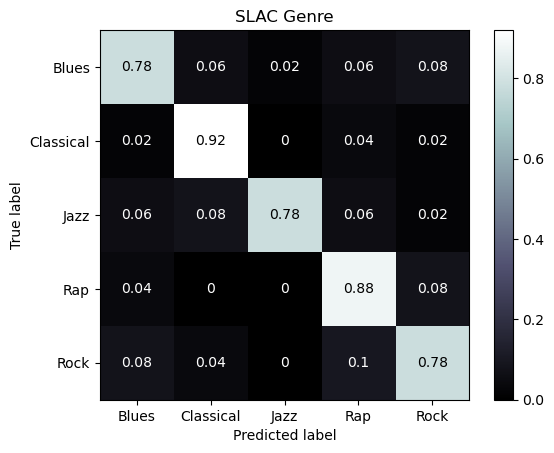

In [21]:
disp = ConfusionMatrixDisplay.from_predictions(y_true=lb.inverse_transform(lb_labels), y_pred=lb.inverse_transform(predicted), cmap='bone', normalize='true')

disp.ax_.set_title('SLAC Genre')
plt.show()

### Genres (Split)

In [22]:
for j in tqdm(range(10)):
    trainX, trainY, testX, testY = data_x[j]


  0%|          | 0/10 [00:00<?, ?it/s]

In [23]:
for j in tqdm(range(10)):
    trainX, trainY, testX, testY = data_x[j]

  0%|          | 0/10 [00:00<?, ?it/s]

In [24]:
scores_5c_split = []

t_stat_s ={}
for j in tqdm(range(10)):
    trainX, trainY, testX, testY = data_x[j]
    trainY_genres = trainY.genre.tolist()
    oh = OneHotEncoder(trainY_genres)

    neural_network.fit(trainX, oh.labels, shuffle=True, verbose=0)

    testX = np.array(testX)
    testY_genres = testY.genre.tolist()
    testY = oh.encoder.transform(testY_genres)
    accuracy = neural_network.score(testX, testY)

    scores_5c_split.append(accuracy)

print(scores_5c_split)
m = np.mean(scores_5c_split)
s = np.std(scores_5c_split)
print('Accuracy: %.3f (%.3f)' % (m, s))

  0%|          | 0/10 [00:00<?, ?it/s]

[0.36666666666666664, 0.5333333333333333, 0.7666666666666667, 0.6333333333333333, 0.6333333333333333, 0.8, 0.75, 0.9, 0.85, 0.6]
Accuracy: 0.683 (0.153)


### Subgenres

In [25]:
onehot = OneHotEncoder(df.subgenre.tolist())

In [30]:
onehot.get(onehot.labels)

array(['Traditional', 'Traditional', 'Traditional', 'Traditional',
       'Traditional', 'Alternative', 'Traditional', 'Traditional',
       'Traditional', 'Traditional'], dtype='<U12')

In [26]:
num_output = onehot.labels.shape[1]

num_input, num_output

(100, 10)

In [27]:
neural_network = KerasClassifier(model=create_model,
                                 epochs=100,
                                 batch_size=32,
                                 verbose=0)


In [28]:
scores_10c = {}
scores_10c_std = {}
for name, d in tqdm(emb_sets.items()):
    print(name)
    scores = cross_val_score(neural_network, d, onehot.labels,
                             cv=KFold(10, shuffle=True, random_state=random_state), verbose=0, n_jobs=-1)
    print(scores)
    scores_10c[name] = np.mean(scores)
    scores_10c_std[name] = np.std(scores)
scores_10c

  0%|          | 0/6 [00:00<?, ?it/s]

ALL
[0.72 0.6  0.6  0.6  0.64 0.72 0.76 0.64 0.52 0.56]
+N
[0.52 0.6  0.64 0.84 0.72 0.6  0.52 0.52 0.4  0.64]
+P
[0.52 0.72 0.6  0.48 0.68 0.52 0.72 0.48 0.56 0.44]
+T
[0.16 0.08 0.2  0.12 0.28 0.24 0.16 0.16 0.16 0.12]
+TS
[0.08 0.04 0.08 0.24 0.16 0.28 0.08 0.24 0.12 0.2 ]
300
[0.72 0.64 0.56 0.44 0.6  0.72 0.56 0.36 0.36 0.52]


{'ALL': 0.6359999999999999,
 '+N': 0.6,
 '+P': 0.5720000000000002,
 '+T': 0.168,
 '+TS': 0.15199999999999997,
 '300': 0.548}